In [72]:
import torch
import torch.nn as nn
import torch.optim as optim
import torcheval.metrics
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, classification_report, confusion_matrix, r2_score, mean_squared_error
import import_ipynb
import data_preprocessing  # Replace with the name of the notebook without `.ipynb`

In [2]:
# training data
u4_train_equil_turbine = data_preprocessing.u4_train_equil_turbine
u4_train_equil_pump = data_preprocessing.u4_train_equil_pump
u5_train_equil_turbine = data_preprocessing.u5_train_equil_turbine
u5_train_equil_pump = data_preprocessing.u5_train_equil_pump
u6_train_equil_turbine = data_preprocessing.u6_train_equil_turbine
u6_train_equil_pump = data_preprocessing.u6_train_equil_pump

# synethetic test sets
u5_s01_equil_turbine = data_preprocessing.u5_s01_equil_turbine
u5_s01_equil_pump = data_preprocessing.u5_s01_equil_pump
u5_s02_equil_turbine = data_preprocessing.u5_s02_equil_turbine
u5_s02_equil_pump = data_preprocessing.u5_s02_equil_pump
u6_s01_equil_turbine = data_preprocessing.u6_s01_equil_turbine
u6_s01_equil_pump = data_preprocessing.u6_s01_equil_pump
u6_s02_equil_turbine = data_preprocessing.u6_s02_equil_turbine
u6_s02_equil_pump = data_preprocessing.u6_s02_equil_pump

# real test sets
u4_test_equil_turbine = data_preprocessing.u4_test_equil_turbine
u4_test_equil_pump = data_preprocessing.u4_test_equil_pump
u5_test_equil_turbine = data_preprocessing.u5_test_equil_turbine
u5_test_equil_pump = data_preprocessing.u5_test_equil_pump
u6_test_equil_turbine = data_preprocessing.u6_test_equil_turbine
u6_test_equil_pump = data_preprocessing.u6_test_equil_pump

In [29]:
u5_control_vars = data_preprocessing.u5_control_vars
print(u5_control_vars)
natural_control_vars = ['canal_level', 'canal_tmp', 'lake_tmp', 'water_primary_cold_tmp']
features = [
    'tot_activepower', 'charge', 'coupler_position', 'injector_01_opening', 'injector_02_opening',
    'injector_03_opening', 'injector_04_opening', 'injector_05_opening', 'pump_calculated_flow',
    'pump_pressure_diff', 'pump_rotspeed', 'turbine_pressure', 'turbine_rotspeed',
    'water_primary_pump_01_opening', 'water_primary_pump_02_opening', 'timer_turbine_on_off', 
    'ext_tmp', 'plant_tmp',
    'minute', 'hour', 'day', 'month', 'year', 'dayofweek','dayofyear', 'is_weekend'
]

['tot_activepower' 'charge' 'coupler_position' 'injector_01_opening'
 'injector_02_opening' 'injector_03_opening' 'injector_04_opening'
 'injector_05_opening' 'pump_calculated_flow' 'pump_pressure_diff'
 'pump_rotspeed' 'turbine_pressure' 'turbine_rotspeed'
 'water_primary_pump_01_opening' 'water_primary_pump_02_opening'
 'timer_turbine_on_off' 'timer_injector_opening']


In [30]:
# Check if 'timer_turbine_on_off' is present; if not, exclude it from the feature list
features = [feature for feature in features if feature in u5_train_equil_pump.columns]

target = 'stat_magn_01_tmp'

# Split the data into training and testing sets
X = u5_train_equil_pump[features]
y = u5_train_equil_pump[target]

In [31]:
class RegressiveNN(nn.Module):
    def __init__(self, input_dim):
        super(RegressiveNN, self).__init__()
        
        self.fc1 = nn.Linear(input_dim, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = self.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        return x

# Initialize the model
input_dim = X.shape[1]
model = RegressiveNN(input_dim)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [32]:
# Convert data to PyTorch tensors
X_tensor = torch.tensor(X.values, dtype=torch.float32)
y_tensor = torch.tensor(y.values, dtype=torch.float32).view(-1, 1)

epochs = 50
batch_size = 32
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    predictions = model(X_tensor)
    loss = criterion(predictions, y_tensor)
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")


Epoch 10/50, Loss: 0.5998
Epoch 20/50, Loss: 0.3714
Epoch 30/50, Loss: 0.3188
Epoch 40/50, Loss: 0.2884
Epoch 50/50, Loss: 0.2709


In [33]:
# Switch the model to evaluation mode
model.eval()

# Predict using the test data
with torch.no_grad():
    reconstructed = model(X_tensor)  # Predictions from the model

# Convert tensors back to numpy for plotting
reconstructed = reconstructed.numpy()
original = y

In [34]:
r2_score(original, reconstructed)

0.7627128152196809

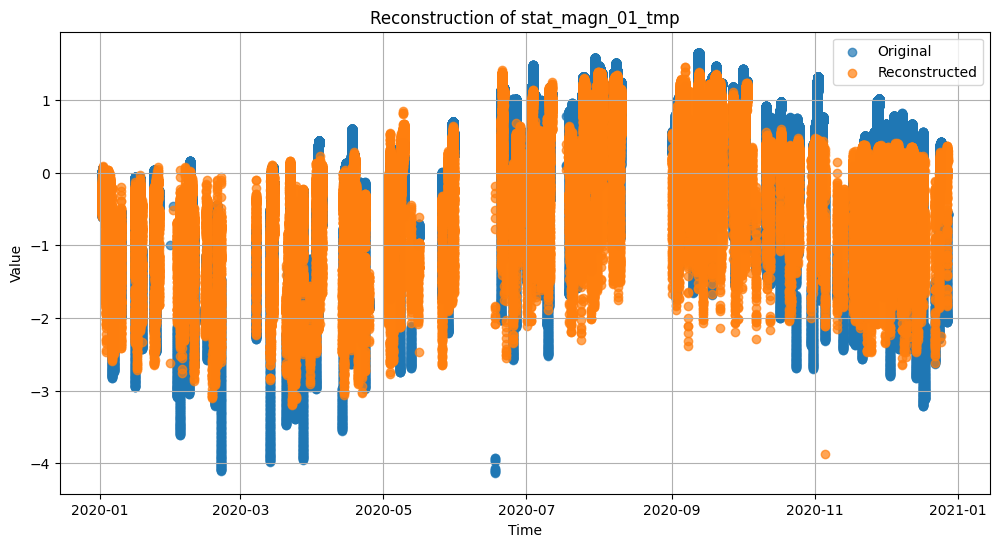

In [35]:
# Convert tensors back to numpy for plotting
time_index = X.index

reconstructed = reconstructed.flatten()  # Ensure predictions are 1D
# original = original.flatten()  # Ensure targets are 1D

# Plot original vs reconstructed with time as the x-axis
plt.figure(figsize=(12, 6))
plt.scatter(time_index, original, label="Original", linewidth=1, alpha=0.7)
plt.scatter(time_index, reconstructed, label="Reconstructed", alpha=0.7)
plt.title('Reconstruction of stat_magn_01_tmp')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()


Prediction on synethetic dataset

In [39]:
# Extracting the features and target from the synthetic test set
X_synthetic = u5_s01_equil_pump[features]
X_synthetic = torch.tensor(X_synthetic.values, dtype=torch.float32)

y_synthetic = u5_s01_equil_pump['stat_magn_01_tmp']
y_synthetic = torch.tensor(y_synthetic.values, dtype=torch.float32).view(-1, 1)


# Predict using the trained model
y_pred_synthetic = model(X_synthetic)

In [58]:
r2_metric = torcheval.metrics.R2Score()

In [61]:
# Evaluate the model performance on synthetic data

mse_synthetic = criterion(y_pred_synthetic, y_synthetic)
r_squared_synthetic = r2_metric.update(y_synthetic, y_pred_synthetic).compute()

print(f'Mean Squared Error on Synthetic Data: {mse_synthetic}')
# print(f'Root Mean Squared Error on Synthetic Data: {rmse_synthetic}')
print(f"R squared : {r_squared_synthetic}")

Mean Squared Error on Synthetic Data: 0.38699835538864136
R squared : 0.42533648014068604


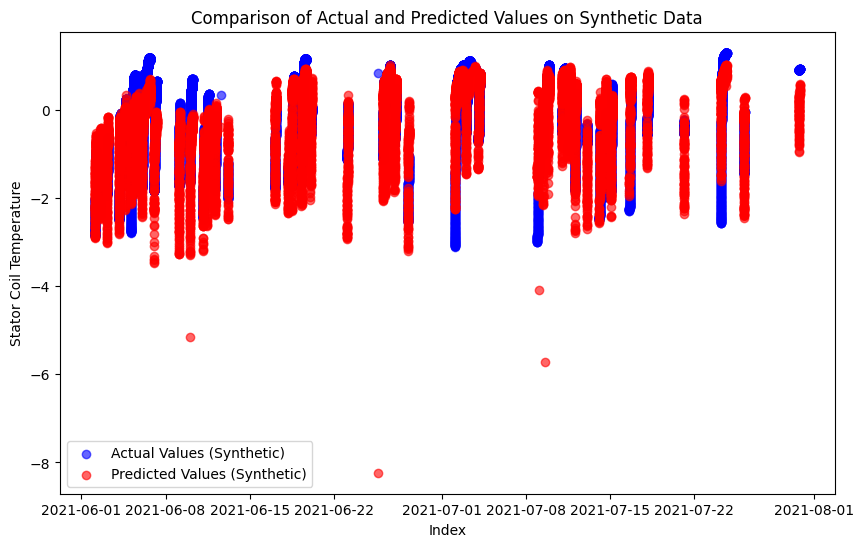

In [64]:
# Visualizing the results with a scatter plot for actual vs predicted values
# Convert predictions to a NumPy array for plotting
y_pred_synthetic_np = y_pred_synthetic.detach().numpy()
y_synthetic_np = y_synthetic.numpy()

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(u5_s01_equil_pump.index, y_synthetic_np, label='Actual Values (Synthetic)', color='blue', alpha=0.6)
plt.scatter(u5_s01_equil_pump.index, y_pred_synthetic_np, label='Predicted Values (Synthetic)', color='red', alpha=0.6)
plt.title('Comparison of Actual and Predicted Values on Synthetic Data')
plt.xlabel('Index')
plt.ylabel('Stator Coil Temperature')
plt.legend()
plt.show()

In [68]:
u5_s01_equil_pump['anomaly'].value_counts()

anomaly
1    20079
0     2120
Name: count, dtype: int64

# Train on all Operating Models

In [78]:
data_preprocessing.add_time_features

<function data_preprocessing.add_time_features(df)>

In [81]:
rds_u5 = data_preprocessing.rds_u5
df = data_preprocessing.add_time_features(rds_u5.data_dict["train"].measurements)

# Check if 'timer_turbine_on_off' is present; if not, exclude it from the feature list
features = [feature for feature in features if feature in u5_train_equil_pump.columns]

target = 'stat_magn_01_tmp'

# Split the data into training and testing sets
X = df[features]
y = df[target]

In [91]:
X

,tot_activepower,charge,coupler_position,injector_01_opening,injector_02_opening,injector_03_opening,injector_04_opening,injector_05_opening,pump_calculated_flow,pump_pressure_diff,...,ext_tmp,plant_tmp,minute,hour,day,month,year,dayofweek,dayofyear,is_weekend
2020-01-02 00:00:00+01:00,-119.619240,-1.590960,185.068454,0.000000,0.000000,0.000000,0.000000,0.000000,12.848305,343.266693,...,5.961580,16.350124,0,0,2,1,2020,3,2,0
2020-01-02 00:00:30+01:00,-119.155684,-1.561455,185.066912,0.000000,0.000000,0.000000,0.000000,0.000000,12.853569,339.333344,...,5.992895,16.349115,0,0,2,1,2020,3,2,0
2020-01-02 00:01:00+01:00,-118.311378,-1.722507,185.065370,0.000000,0.000000,0.000000,0.000000,0.000000,12.876725,334.483337,...,6.024210,16.348106,1,0,2,1,2020,3,2,0
2020-01-02 00:01:30+01:00,-118.286427,-1.555196,185.063829,0.000000,0.000000,0.000000,0.000000,0.000000,12.899880,332.980011,...,6.055526,16.347098,1,0,2,1,2020,3,2,0
2020-01-02 00:02:00+01:00,-118.326697,-1.655334,185.062287,0.000000,0.000000,0.000000,0.000000,0.000000,12.923036,331.883362,...,6.086841,16.346089,2,0,2,1,2020,3,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-30 23:58:00+01:00,-28.132401,-36.122673,185.263112,15.440604,14.641031,16.038757,14.518959,14.818036,13.786380,382.250031,...,9.937729,15.510648,58,23,30,12,2020,2,365,0
2020-12-30 23:58:30+01:00,-32.924961,-36.113546,184.996425,39.537651,39.421684,39.409477,39.171436,39.598686,13.346910,355.258347,...,9.946683,15.509096,58,23,30,12,2020,2,365,0
2020-12-30 23:59:00+01:00,-40.567806,-43.350670,184.999200,34.117645,33.934540,33.995575,33.934540,33.995575,12.890941,339.483337,...,9.955638,15.507544,59,23,30,12,2020,2,365,0
2020-12-30 23:59:30+01:00,-60.917969,-62.244003,185.001975,0.000000,32.841991,32.435084,25.383383,32.780956,13.066450,343.716675,...,9.964592,15.505992,59,23,30,12,2020,2,365,0


In [84]:
# Convert data to PyTorch tensors
X_tensor = torch.tensor(X.values, dtype=torch.float32)
y_tensor = torch.tensor(y.values, dtype=torch.float32).view(-1, 1)

epochs = 50
batch_size = 32
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    predictions = model(X_tensor)
    loss = criterion(predictions, y_tensor)
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")


Epoch 10/50, Loss: 2842.4612
Epoch 20/50, Loss: 2715.2883
Epoch 30/50, Loss: 2542.6670
Epoch 40/50, Loss: 2320.8545
Epoch 50/50, Loss: 2055.9661


In [85]:
# Switch the model to evaluation mode
model.eval()

# Predict using the test data
with torch.no_grad():
    reconstructed = model(X_tensor)  # Predictions from the model

# Convert tensors back to numpy for plotting
reconstructed = reconstructed.numpy()
original = y
r2_score(original, reconstructed)


-13.276912790927009

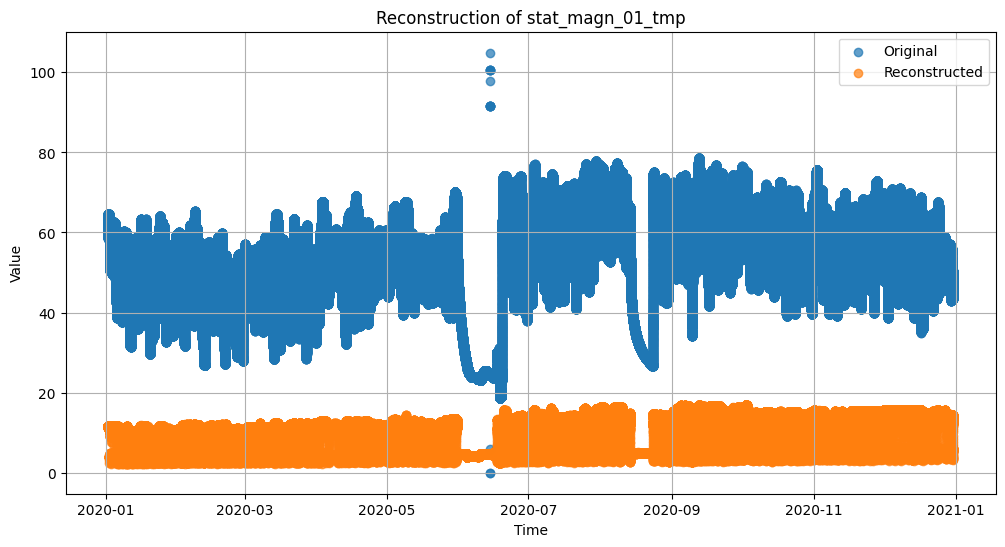

In [86]:
# Convert tensors back to numpy for plotting
time_index = X.index

reconstructed = reconstructed.flatten()  # Ensure predictions are 1D
# original = original.flatten()  # Ensure targets are 1D

# Plot original vs reconstructed with time as the x-axis
plt.figure(figsize=(12, 6))
plt.scatter(time_index, original, label="Original", linewidth=1, alpha=0.7)
plt.scatter(time_index, reconstructed, label="Reconstructed", alpha=0.7)
plt.title('Reconstruction of stat_magn_01_tmp')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()


## LSTM Model

In [36]:
import torch.nn as nn

class LSTMRegressor(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, dropout=0.2):
        super(LSTMRegressor, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim)
        )
    
    def forward(self, x):
        # LSTM output: (batch_size, seq_length, hidden_dim)
        lstm_out, _ = self.lstm(x)
        # Take the last timestep's output
        out = lstm_out[:, -1, :]
        return self.fc(out)

# Model parameters
input_dim = X_train_scaled.shape[1]  # Number of control measurements
hidden_dim = 128  # Hidden units in LSTM
output_dim = 1  # Single target variable
num_layers = 2  # Number of LSTM layers

model = LSTMRegressor(input_dim, hidden_dim, output_dim, num_layers)


NameError: name 'X_train_scaled' is not defined

In [ ]:
def create_sequences(data, target, seq_length):
    sequences, labels = [], []
    for i in range(len(data) - seq_length):
        sequences.append(data[i : i + seq_length])
        labels.append(target[i + seq_length])
    return torch.stack(sequences), torch.stack(labels)

seq_length = 10  # Example: 10 timesteps per sequence
x_seq, y_seq = create_sequences(X_train_tensor, y_train_tensor, seq_length)

# Create DataLoader
class TimeSeriesDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

train_loader = DataLoader(TimeSeriesDataset(x_seq, y_seq), batch_size=32, shuffle=True)
# test_loader = DataLoader(TimeSeriesDataset(X_train_tensor, y_train_scaled), batch_size=32, shuffle=False)


In [ ]:
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32).view(-1, 1)
X_train_tensor.shape

torch.Size([1047207, 15])

In [ ]:
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    for x_batch, y_batch in train_loader:
        # print(x_batch.shape)  # Expected: (batch_size, seq_length, input_size)
        optimizer.zero_grad()
        predictions = model(x_batch)
        # print(predictions)
        loss = criterion(predictions, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader):.4f}")


Epoch 1/50, Loss: 0.9992
Epoch 2/50, Loss: 0.9992
Epoch 3/50, Loss: 0.9992
Epoch 4/50, Loss: 0.9992
Epoch 5/50, Loss: 0.9992
Epoch 6/50, Loss: 0.9992
Epoch 7/50, Loss: 0.9992
Epoch 8/50, Loss: 0.9992
Epoch 9/50, Loss: 0.9992
Epoch 10/50, Loss: 0.9992
Epoch 11/50, Loss: 0.9992
Epoch 12/50, Loss: 0.9992
Epoch 13/50, Loss: 0.9992
Epoch 14/50, Loss: 0.9992
Epoch 15/50, Loss: 0.9992
Epoch 16/50, Loss: 0.9992
Epoch 17/50, Loss: 0.9992
Epoch 18/50, Loss: 0.9992
Epoch 19/50, Loss: 0.9992
Epoch 20/50, Loss: 0.9992
Epoch 21/50, Loss: 0.9992
Epoch 22/50, Loss: 0.9992
Epoch 23/50, Loss: 0.9992


KeyboardInterrupt: 